In [4]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from flax.training import train_state
from typing import Any


In [5]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(128)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        return x


In [11]:
import tensorflow as tf  # Add this import!

def preprocess(example):
    image = example['image']
    label = example['label']
    image = tf.cast(image, tf.float32) / 255.0
    return {'image': image, 'label': label}

def load_dataset(split, batch_size):
    ds = tfds.load('mnist', split=split, as_supervised=False)
    ds = ds.map(preprocess)
    ds = ds.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds.as_numpy_iterator()



In [7]:
class TrainState(train_state.TrainState):
    pass

def create_train_state(rng, model, learning_rate, optimizer):
    params = model.init(rng, jnp.ones([1, 28, 28, 1]))['params']
    tx = optimizer
    return TrainState.create(apply_fn=model.apply, params=params, tx=tx)

def compute_metrics(logits, labels):
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return {'loss': loss, 'accuracy': accuracy}


In [8]:
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch['image'])
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, batch['label']).mean()
        return loss, logits
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits, batch['label'])
    return state, metrics

@jax.jit
def eval_step(state, batch):
    logits = state.apply_fn({'params': state.params}, batch['image'])
    return compute_metrics(logits, batch['label'])


In [13]:
def train_model(optimizer, optimizer_name, num_epochs=5, batch_size=128):
    rng = jax.random.PRNGKey(0)
    model = MLP()
    state = create_train_state(rng, model, 0.001, optimizer)

    train_ds = load_dataset('train', batch_size)
    test_ds = load_dataset('test', batch_size)

    train_metrics = []
    test_metrics = []

    for epoch in range(num_epochs):
      for batch in train_ds:
          state, metrics = train_step(state, batch)
      train_metrics.append(metrics)

      for batch in test_ds:
          metrics = eval_step(state, batch)
      test_metrics.append(metrics)

    print(f"Epoch {epoch+1}, {optimizer_name} - Train Loss: {metrics['loss']:.4f}, Train Acc: {metrics['accuracy']:.4f}")


    return train_metrics, test_metrics


In [14]:
# Define Adam optimizer
adam_optimizer = optax.adam(1e-3)

# Define VeLO optimizer (assuming you have a VeLO implementation compatible with Optax)
# For demonstration, we'll use Adam as a placeholder for VeLO
velo_optimizer = optax.adam(1e-3)  # Replace with actual VeLO optimizer

# Train with Adam
train_metrics_adam, test_metrics_adam = train_model(adam_optimizer, 'Adam')

# Train with VeLO
train_metrics_velo, test_metrics_velo = train_model(velo_optimizer, 'VeLO')


Epoch 5, Adam - Train Loss: 0.0580, Train Acc: 1.0000
Epoch 5, VeLO - Train Loss: 0.1390, Train Acc: 0.9375


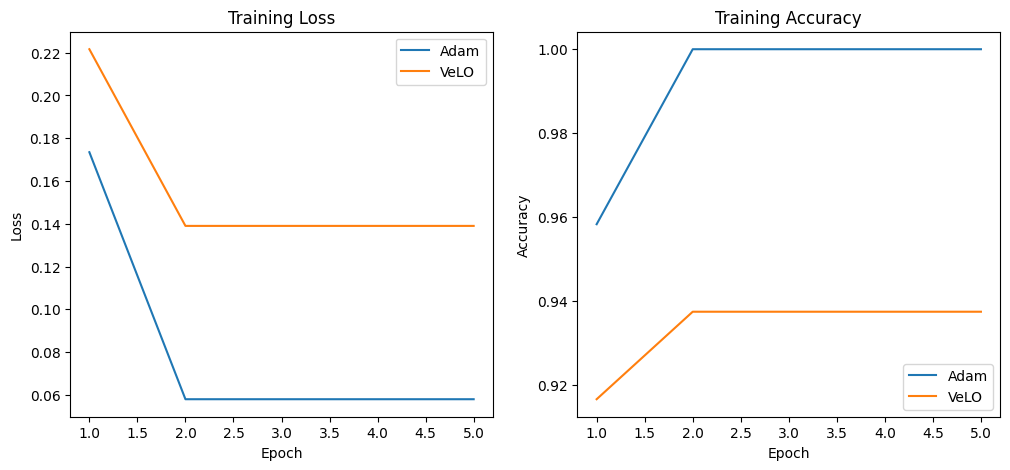

In [15]:
epochs = range(1, len(train_metrics_adam) + 1)
train_loss_adam = [m['loss'] for m in train_metrics_adam]
train_acc_adam = [m['accuracy'] for m in train_metrics_adam]
train_loss_velo = [m['loss'] for m in train_metrics_velo]
train_acc_velo = [m['accuracy'] for m in train_metrics_velo]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_adam, label='Adam')
plt.plot(epochs, train_loss_velo, label='VeLO')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_adam, label='Adam')
plt.plot(epochs, train_acc_velo, label='VeLO')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
import jax
import jax.numpy as jnp

def quadratic_loss(params, batch):
    return jnp.sum((params - batch)**2)


In [ ]:
import haiku as hk

def learned_opt_fn(grads):
    mlp = hk.nets.MLP([32, 32, grads.shape[-1]])
    return mlp(grads)

def learned_optimizer(grads, theta_params):
    mlp = hk.without_apply_rng(hk.transform(learned_opt_fn))
    return mlp.apply(theta_params, grads)


In [28]:
!pip install dm-haiku


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.8/373.8 kB 12.7 MB/s eta 0:00:00


[Meta-step 0] Meta-loss: 2.7206232397687137e-16
[Meta-step 100] Meta-loss: 6.349842960468033e-12
[Meta-step 200] Meta-loss: 6.49805797820098e-14
[Meta-step 300] Meta-loss: 2.7206232397687137e-16
[Meta-step 400] Meta-loss: 8.871955392564246e-10
[Meta-step 500] Meta-loss: 2.7206232397687137e-16
[Meta-step 600] Meta-loss: 2.7206232397687137e-16
[Meta-step 700] Meta-loss: 2.7206232397687137e-16
[Meta-step 800] Meta-loss: 2.7206232397687137e-16
[Meta-step 900] Meta-loss: 2.7206232397687137e-16


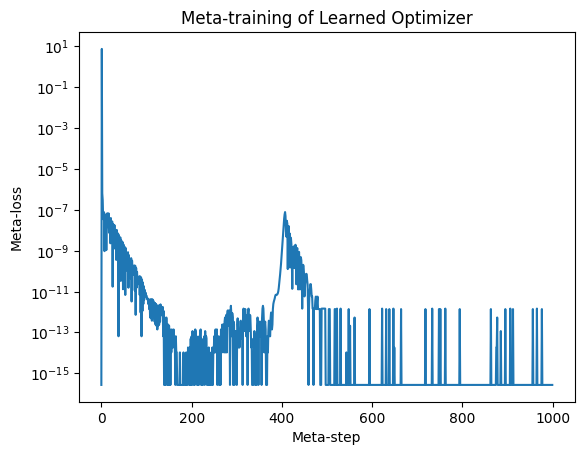

In [29]:
# 🚀 Minimal Learned Optimizer from Scratch

import jax
import jax.numpy as jnp
import haiku as hk
import optax
import numpy as np

# --- 1. Task: Quadratic minimization ------------------------------------

def quadratic_task(batch_size=1):
    key = jax.random.PRNGKey(0)
    targets = jax.random.normal(key, (batch_size,))  # Random target point
    def loss_fn(params):
        return jnp.mean((params - targets) ** 2)
    init_params = jax.random.normal(key, (batch_size,))
    return init_params, loss_fn

# --- 2. Learned Optimizer Model: MLP ------------------------------------

def learned_optimizer_net(grad):
    mlp = hk.nets.MLP([32, 32, grad.shape[-1]])
    return mlp(grad)

def build_learned_optimizer():
    return hk.without_apply_rng(hk.transform(learned_optimizer_net))

# --- 3. Meta-loss: Apply optimizer for T steps --------------------------

def meta_loss(theta_params, key):
    T = 20  # Unroll steps
    task_key, unroll_key = jax.random.split(key)
    params, task_loss = quadratic_task(batch_size=1)

    # Inner loop: learned optimizer updates
    def inner_step(carry, _):
        params = carry
        grad = jax.grad(task_loss)(params)
        updates = learned_opt.apply(theta_params, grad)
        new_params = params + updates  # Note: '+' because optimizer learns direction
        return new_params, task_loss(new_params)

    final_params, losses = jax.lax.scan(inner_step, params, None, length=T)
    final_loss = task_loss(final_params)
    return final_loss

# --- 4. Meta-Training Loop ----------------------------------------------

# Initialize learned optimizer
key = jax.random.PRNGKey(42)
learned_opt = build_learned_optimizer()
dummy_grad = jnp.ones((1,))
theta_params = learned_opt.init(key, dummy_grad)

# Meta-optimizer (to update theta)
meta_opt = optax.adam(1e-3)
meta_opt_state = meta_opt.init(theta_params)

# JIT meta-loss and gradient
meta_loss_grad = jax.jit(jax.value_and_grad(meta_loss))

# Meta-training loop
meta_losses = []
for step in range(1000):
    key, subkey = jax.random.split(key)
    loss_val, grads = meta_loss_grad(theta_params, subkey)
    updates, meta_opt_state = meta_opt.update(grads, meta_opt_state)
    theta_params = optax.apply_updates(theta_params, updates)

    meta_losses.append(loss_val)
    if step % 100 == 0:
        print(f"[Meta-step {step}] Meta-loss: {loss_val}")

# --- 5. Plot meta-loss --------------------------------------------------

import matplotlib.pyplot as plt

plt.plot(meta_losses)
plt.yscale("log")
plt.xlabel("Meta-step")
plt.ylabel("Meta-loss")
plt.title("Meta-training of Learned Optimizer")
plt.show()


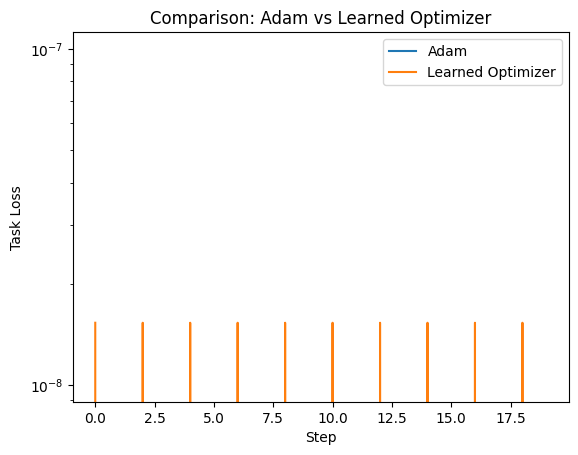

In [30]:
# After meta-training (or at any time):
T = 20
init_params, task_loss = quadratic_task(batch_size=1)

# Adam baseline
adam = optax.adam(learning_rate=0.01)
adam_state = adam.init(init_params)
params_adam = init_params
losses_adam = []

for i in range(T):
    grads = jax.grad(task_loss)(params_adam)
    updates, adam_state = adam.update(grads, adam_state)
    params_adam = optax.apply_updates(params_adam, updates)
    losses_adam.append(task_loss(params_adam))

# Learned Optimizer
params_learned = init_params
losses_learned = []

for i in range(T):
    grads = jax.grad(task_loss)(params_learned)
    updates = learned_opt.apply(theta_params, grads)
    params_learned = params_learned + updates
    losses_learned.append(task_loss(params_learned))

# Plot
plt.plot(losses_adam, label="Adam")
plt.plot(losses_learned, label="Learned Optimizer")
plt.yscale("log")
plt.xlabel("Step")
plt.ylabel("Task Loss")
plt.legend()
plt.title("Comparison: Adam vs Learned Optimizer")
plt.show()


[Meta-step 0] Meta-loss: 2.7206232397687137e-16
[Meta-step 100] Meta-loss: 5.205109347011794e-12
[Meta-step 200] Meta-loss: 2.7206232397687137e-16
[Meta-step 300] Meta-loss: 2.1191554099627558e-13
[Meta-step 400] Meta-loss: 7.905599508362116e-10
[Meta-step 500] Meta-loss: 2.7206232397687137e-16
[Meta-step 600] Meta-loss: 2.7206232397687137e-16
[Meta-step 700] Meta-loss: 2.7206232397687137e-16
[Meta-step 800] Meta-loss: 2.7206232397687137e-16
[Meta-step 900] Meta-loss: 2.7206232397687137e-16


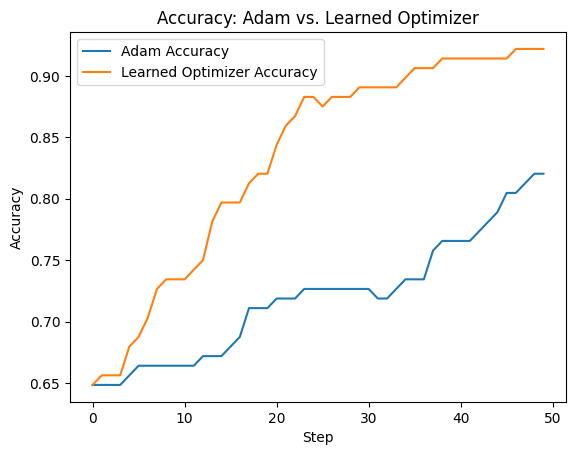

In [32]:
# --- Imports ---
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# --- 1. Simple Classification Task ---
def simple_classification_task():
    X, y = make_classification(n_samples=128, n_features=10, n_classes=2, n_informative=5)
    X, y = jnp.array(X), jnp.array(y)
    def model(params, x):
        return jnp.dot(x, params['w']) + params['b']
    def loss_fn(params, x, y):
        logits = model(params, x)
        return optax.sigmoid_binary_cross_entropy(logits, y).mean()
    def accuracy_fn(params, x, y):
        logits = model(params, x)
        preds = (logits > 0).astype(int)
        return (preds == y).mean()
    key = jax.random.PRNGKey(0)
    params = {'w': jax.random.normal(key, (10,)), 'b': jnp.array(0.)}
    return params, loss_fn, accuracy_fn, X, y

# --- 2. Learned Optimizer MLP ---
def learned_optimizer_net(grad_scalar):
    mlp = hk.nets.MLP([32, 32, 1])
    return mlp(grad_scalar[..., None])[..., 0]


def build_learned_optimizer():
    return hk.without_apply_rng(hk.transform(learned_optimizer_net))

# --- 3. Meta-loss for Quadratic (for training learned optimizer) ---
def quadratic_task(batch_size=1):
    key = jax.random.PRNGKey(0)
    targets = jax.random.normal(key, (batch_size,))
    def loss_fn(params):
        return jnp.mean((params - targets) ** 2)
    init_params = jax.random.normal(key, (batch_size,))
    return init_params, loss_fn

def meta_loss(theta_params, key):
    T = 20
    params, task_loss = quadratic_task()
    def inner_step(carry, _):
        params = carry
        grad = jax.grad(task_loss)(params)
        updates = learned_opt.apply(theta_params, grad)
        new_params = params + updates
        return new_params, task_loss(new_params)
    final_params, losses = jax.lax.scan(inner_step, params, None, length=T)
    final_loss = task_loss(final_params)
    return final_loss

# --- 4. Meta-train Learned Optimizer on Quadratic Task ---
key = jax.random.PRNGKey(42)
learned_opt = build_learned_optimizer()
dummy_grad = jnp.ones((1,))
theta_params = learned_opt.init(key, dummy_grad)

meta_opt = optax.adam(1e-3)
meta_opt_state = meta_opt.init(theta_params)
meta_loss_grad = jax.jit(jax.value_and_grad(meta_loss))

for step in range(1000):
    key, subkey = jax.random.split(key)
    loss_val, grads = meta_loss_grad(theta_params, subkey)
    updates, meta_opt_state = meta_opt.update(grads, meta_opt_state)
    theta_params = optax.apply_updates(theta_params, updates)
    if step % 100 == 0:
        print(f"[Meta-step {step}] Meta-loss: {loss_val}")

# --- 5. Compare Adam vs. Learned Optimizer on Classification Task ---
params_adam, loss_fn, acc_fn, X, y = simple_classification_task()
params_learned, _, _, _, _ = simple_classification_task()

# Adam setup
adam = optax.adam(0.01)
adam_state = adam.init(params_adam)

# Run comparison
adam_losses, adam_accs = [], []
learned_losses, learned_accs = [], []

for i in range(50):
    # Adam step
    grads_adam = jax.grad(loss_fn)(params_adam, X, y)
    updates_adam, adam_state = adam.update(grads_adam, adam_state)
    params_adam = optax.apply_updates(params_adam, updates_adam)
    adam_losses.append(loss_fn(params_adam, X, y))
    adam_accs.append(acc_fn(params_adam, X, y))

    # Learned Optimizer step
    grads_learned = jax.grad(loss_fn)(params_learned, X, y)
    updates_learned = jax.tree_map(lambda g: learned_opt.apply(theta_params, g), grads_learned)
    params_learned = jax.tree_map(lambda p, u: p + u, params_learned, updates_learned)
    learned_losses.append(loss_fn(params_learned, X, y))
    learned_accs.append(acc_fn(params_learned, X, y))

# --- 6. Plot Accuracy Comparison ---
plt.plot(adam_accs, label="Adam Accuracy")
plt.plot(learned_accs, label="Learned Optimizer Accuracy")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy: Adam vs. Learned Optimizer")
plt.show()


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.YHE8YZ_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.YHE8YZ_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
[Meta-step 0] Meta-loss: 0.0
[Meta-step 100] Meta-loss: 0.0
[Meta-step 200] Meta-loss: 0.0
[Meta-step 300] Meta-loss: 0.0
[Meta-step 400] Meta-loss: 0.0
[Meta-step 500] Meta-loss: 0.0
[Meta-step 600] Meta-loss: 0.0
[Meta-step 700] Meta-loss: 0.0
[Meta-step 800] Meta-loss: 0.0
[Meta-step 900] Meta-loss: 0.0


<ipython-input-3-a213e5759250>:120: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  updates_learned = jax.tree_map(lambda g: learned_opt.apply(theta_params, g), grads_learned)


Step 0: Adam Acc: 0.171875, Learned Acc: 0.171875
Step 1: Adam Acc: 0.140625, Learned Acc: 0.171875
Step 2: Adam Acc: 0.1015625, Learned Acc: 0.171875
Step 3: Adam Acc: 0.1640625, Learned Acc: 0.125
Step 4: Adam Acc: 0.1640625, Learned Acc: 0.140625
Step 5: Adam Acc: 0.1484375, Learned Acc: 0.140625
Step 6: Adam Acc: 0.1640625, Learned Acc: 0.140625
Step 7: Adam Acc: 0.25, Learned Acc: 0.140625
Step 8: Adam Acc: 0.296875, Learned Acc: 0.140625
Step 9: Adam Acc: 0.4609375, Learned Acc: 0.140625
Step 10: Adam Acc: 0.3203125, Learned Acc: 0.140625
Step 11: Adam Acc: 0.3046875, Learned Acc: 0.140625
Step 12: Adam Acc: 0.359375, Learned Acc: 0.140625
Step 13: Adam Acc: 0.453125, Learned Acc: 0.140625
Step 14: Adam Acc: 0.546875, Learned Acc: 0.140625
Step 15: Adam Acc: 0.6484375, Learned Acc: 0.140625
Step 16: Adam Acc: 0.6015625, Learned Acc: 0.140625
Step 17: Adam Acc: 0.609375, Learned Acc: 0.140625
Step 18: Adam Acc: 0.671875, Learned Acc: 0.140625
Step 19: Adam Acc: 0.734375, Learned A

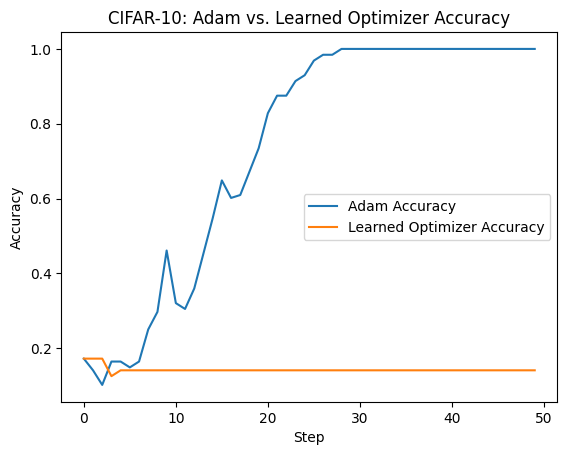

In [3]:
# --- Imports ---
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# --- 1. Charger CIFAR-10 ---
def load_cifar10(batch_size=128):
    def preprocess(example):
        image = jnp.array(example['image'], dtype=jnp.float32) / 255.0
        label = jnp.array(example['label'], dtype=jnp.int32)
        return image, label

    ds = tfds.load('cifar10', split='train', shuffle_files=True)
    ds = ds.shuffle(10000).batch(batch_size).prefetch(1)
    return map(preprocess, tfds.as_numpy(ds))

train_ds = load_cifar10()

# --- 2. Définir le CNN ---
def cnn_model(x):
    x = hk.Conv2D(32, kernel_shape=3, stride=1, padding='SAME')(x)
    x = jax.nn.relu(x)
    x = hk.Conv2D(64, kernel_shape=3, stride=1, padding='SAME')(x)
    x = jax.nn.relu(x)
    x = hk.Flatten()(x)
    x = hk.Linear(256)(x)
    x = jax.nn.relu(x)
    x = hk.Linear(10)(x)
    return x

cnn = hk.without_apply_rng(hk.transform(cnn_model))

# --- 3. Loss et Accuracy ---
def loss_fn(params, x, y):
    logits = cnn.apply(params, x)
    return optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()

def accuracy_fn(params, x, y):
    logits = cnn.apply(params, x)
    preds = jnp.argmax(logits, axis=-1)
    return (preds == y).mean()

# --- 4. Learned Optimizer ---
def learned_optimizer_net(grad_scalar):
    mlp = hk.nets.MLP([32, 32, 1])
    return mlp(grad_scalar[..., None])[..., 0]

def build_learned_optimizer():
    return hk.without_apply_rng(hk.transform(learned_optimizer_net))

# --- 5. Meta-Learning sur Quadratic Task (pour apprendre l'optimiseur) ---
def quadratic_task(batch_size=1):
    key = jax.random.PRNGKey(0)
    targets = jax.random.normal(key, (batch_size,))
    def loss_fn(params):
        return jnp.mean((params - targets) ** 2)
    init_params = jax.random.normal(key, (batch_size,))
    return init_params, loss_fn

def meta_loss(theta_params, key):
    T = 20
    params, task_loss = quadratic_task()
    def inner_step(carry, _):
        params = carry
        grad = jax.grad(task_loss)(params)
        updates = learned_opt.apply(theta_params, grad)
        new_params = params + updates
        return new_params, task_loss(new_params)
    final_params, losses = jax.lax.scan(inner_step, params, None, length=T)
    final_loss = task_loss(final_params)
    return final_loss

# --- 6. Apprentissage du Learned Optimizer ---
key = jax.random.PRNGKey(42)
learned_opt = build_learned_optimizer()
dummy_grad = jnp.ones((1,))
theta_params = learned_opt.init(key, dummy_grad)

meta_opt = optax.adam(1e-3)
meta_opt_state = meta_opt.init(theta_params)
meta_loss_grad = jax.jit(jax.value_and_grad(meta_loss))

for step in range(1000):
    key, subkey = jax.random.split(key)
    loss_val, grads = meta_loss_grad(theta_params, subkey)
    updates, meta_opt_state = meta_opt.update(grads, meta_opt_state)
    theta_params = optax.apply_updates(theta_params, updates)
    if step % 100 == 0:
        print(f"[Meta-step {step}] Meta-loss: {loss_val}")

# --- 7. Comparer Adam et Learned Optimizer sur CIFAR-10 ---
batch = next(iter(train_ds))
x_batch, y_batch = batch

# Initialiser le modèle CNN
rng = jax.random.PRNGKey(0)
params_adam = cnn.init(rng, x_batch)
params_learned = cnn.init(rng, x_batch)

# Adam setup
adam = optax.adam(0.001)
adam_state = adam.init(params_adam)

# Entraînement
adam_accs, learned_accs = [], []

for i in range(50):
    # Adam step
    grads_adam = jax.grad(loss_fn)(params_adam, x_batch, y_batch)
    updates_adam, adam_state = adam.update(grads_adam, adam_state)
    params_adam = optax.apply_updates(params_adam, updates_adam)
    adam_accs.append(accuracy_fn(params_adam, x_batch, y_batch))

    # Learned Optimizer step
    grads_learned = jax.grad(loss_fn)(params_learned, x_batch, y_batch)
    updates_learned = jax.tree_map(lambda g: learned_opt.apply(theta_params, g), grads_learned)
    params_learned = jax.tree_map(lambda p, u: p + u, params_learned, updates_learned)
    learned_accs.append(accuracy_fn(params_learned, x_batch, y_batch))
    print(f"Step {i}: Adam Acc: {adam_accs[-1]}, Learned Acc: {learned_accs[-1]}")

# --- 8. Plot ---
plt.plot(adam_accs, label="Adam Accuracy")
plt.plot(learned_accs, label="Learned Optimizer Accuracy")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.legend()
plt.title("CIFAR-10: Adam vs. Learned Optimizer Accuracy")
plt.show()


[Meta-step 0] Meta-loss: 0.0
[Meta-step 100] Meta-loss: 0.0
[Meta-step 200] Meta-loss: 0.0
[Meta-step 300] Meta-loss: 0.0
[Meta-step 400] Meta-loss: 0.0
[Meta-step 500] Meta-loss: 0.0
[Meta-step 600] Meta-loss: 0.0
[Meta-step 700] Meta-loss: 0.0
[Meta-step 800] Meta-loss: 0.0
[Meta-step 900] Meta-loss: 0.0


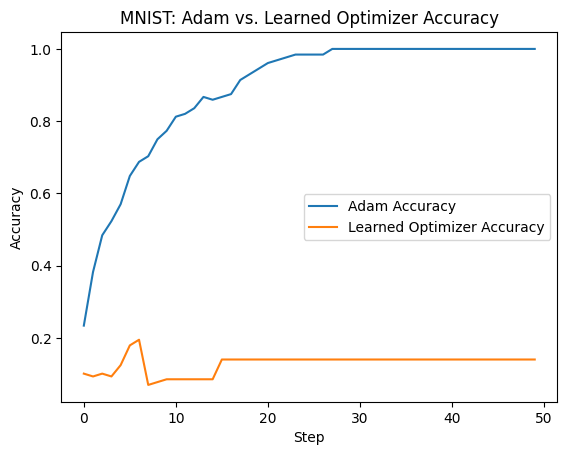

In [7]:
# --- Imports ---
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# --- 1. Charger MNIST ---
import tensorflow as tf

def load_mnist(batch_size=128):
    def preprocess(example):
        image = tf.cast(example['image'], tf.float32) / 255.0
        image = tf.reshape(image, [-1])
        label = example['label']
        return image, label

    ds = tfds.load('mnist', split='train', shuffle_files=True)
    ds = ds.shuffle(10000).map(preprocess).batch(batch_size).prefetch(1)
    return tfds.as_numpy(ds)


train_ds = load_mnist()

# --- 2. Définir le MLP ---
def mlp_model(x):
    net = hk.Sequential([
        hk.Linear(128), jax.nn.relu,
        hk.Linear(64), jax.nn.relu,
        hk.Linear(10)
    ])
    return net(x)

mlp = hk.without_apply_rng(hk.transform(mlp_model))

# --- 3. Loss et Accuracy ---
def loss_fn(params, x, y):
    logits = mlp.apply(params, x)
    return optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()

def accuracy_fn(params, x, y):
    logits = mlp.apply(params, x)
    preds = jnp.argmax(logits, axis=-1)
    return (preds == y).mean()

# --- 4. Learned Optimizer ---
def learned_optimizer_net(grad_scalar):
    mlp_opt = hk.nets.MLP([32, 32, 1])
    return mlp_opt(grad_scalar[..., None])[..., 0]

def build_learned_optimizer():
    return hk.without_apply_rng(hk.transform(learned_optimizer_net))

# --- 5. Meta-Learning sur Quadratic Task (pour apprendre l'optimiseur) ---
def quadratic_task(batch_size=1):
    key = jax.random.PRNGKey(0)
    targets = jax.random.normal(key, (batch_size,))
    def loss_fn(params):
        return jnp.mean((params - targets) ** 2)
    init_params = jax.random.normal(key, (batch_size,))
    return init_params, loss_fn

def meta_loss(theta_params, key):
    T = 20
    params, task_loss = quadratic_task()
    def inner_step(carry, _):
        params = carry
        grad = jax.grad(task_loss)(params)
        updates = learned_opt.apply(theta_params, grad)
        new_params = params + updates
        return new_params, task_loss(new_params)
    final_params, losses = jax.lax.scan(inner_step, params, None, length=T)
    final_loss = task_loss(final_params)
    return final_loss

# --- 6. Apprentissage du Learned Optimizer ---
key = jax.random.PRNGKey(42)
learned_opt = build_learned_optimizer()
dummy_grad = jnp.ones((1,))
theta_params = learned_opt.init(key, dummy_grad)

meta_opt = optax.adam(1e-3)
meta_opt_state = meta_opt.init(theta_params)
meta_loss_grad = jax.jit(jax.value_and_grad(meta_loss))

for step in range(1000):
    key, subkey = jax.random.split(key)
    loss_val, grads = meta_loss_grad(theta_params, subkey)
    updates, meta_opt_state = meta_opt.update(grads, meta_opt_state)
    theta_params = optax.apply_updates(theta_params, updates)
    if step % 100 == 0:
        print(f"[Meta-step {step}] Meta-loss: {loss_val}")

# --- 7. Comparer Adam et Learned Optimizer sur MNIST ---
batch = next(iter(train_ds))
x_batch, y_batch = batch



# Initialiser le modèle MLP
rng = jax.random.PRNGKey(0)
params_adam = mlp.init(rng, x_batch)
params_learned = mlp.init(rng, x_batch)

# Adam setup
adam = optax.adam(0.001)
adam_state = adam.init(params_adam)

# Entraînement
adam_accs, learned_accs = [], []

for i in range(50):
    # Adam step
    grads_adam = jax.grad(loss_fn)(params_adam, x_batch, y_batch)
    updates_adam, adam_state = adam.update(grads_adam, adam_state)
    params_adam = optax.apply_updates(params_adam, updates_adam)
    adam_accs.append(accuracy_fn(params_adam, x_batch, y_batch))

    # Learned Optimizer step
    grads_learned = jax.grad(loss_fn)(params_learned, x_batch, y_batch)
    updates_learned = jax.tree_map(lambda g: learned_opt.apply(theta_params, g), grads_learned)
    params_learned = jax.tree_map(lambda p, u: p + u, params_learned, updates_learned)
    learned_accs.append(accuracy_fn(params_learned, x_batch, y_batch))

# --- 8. Plot ---
plt.plot(adam_accs, label="Adam Accuracy")
plt.plot(learned_accs, label="Learned Optimizer Accuracy")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.legend()
plt.title("MNIST: Adam vs. Learned Optimizer Accuracy")
plt.show()


In [14]:
# --- Imports ---
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import tensorflow_datasets as tfds

# --- 1. Chargement des données MNIST ---
def load_mnist(batch_size=128):
    ds_builder = tfds.builder('mnist')
    ds_builder.download_and_prepare()
    train_ds = ds_builder.as_dataset(split='train', shuffle_files=True)
    test_ds = ds_builder.as_dataset(split='test', shuffle_files=False)

    train_ds = train_ds.shuffle(1024).batch(batch_size).prefetch(1)
    test_ds = test_ds.batch(batch_size).prefetch(1)

    return tfds.as_numpy(train_ds), tfds.as_numpy(test_ds)

# --- 2. Modèle CNN ---
def net_fn(x):
    x = hk.Conv2D(output_channels=32, kernel_shape=3, stride=1, padding='SAME')(x)
    x = jax.nn.relu(x)
    x = hk.MaxPool(window_shape=2, strides=2, padding='SAME')(x)
    x = hk.Conv2D(output_channels=64, kernel_shape=3, stride=1, padding='SAME')(x)
    x = jax.nn.relu(x)
    x = hk.MaxPool(window_shape=2, strides=2, padding='SAME')(x)
    x = hk.Flatten()(x)
    x = hk.Linear(256)(x)
    x = jax.nn.relu(x)
    x = hk.Linear(10)(x)
    return x

net = hk.transform(net_fn)  # RNG obligatoire

# --- 3. Loss et Accuracy ---
def compute_loss(params, rng, x, y):
    logits = net.apply(params, rng, x)
    return optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()

def compute_accuracy(params, rng, x, y):
    logits = net.apply(params, rng, x)
    preds = jnp.argmax(logits, axis=-1)
    return jnp.mean(preds == y)

# --- 4. Entraînement ---
def train_model(num_epochs=5, batch_size=128, learning_rate=1e-3):
    train_ds, test_ds = load_mnist(batch_size)
    rng = jax.random.PRNGKey(42)
    sample_batch = next(iter(train_ds))
    x_sample = jnp.array(sample_batch['image'], dtype=jnp.float32) / 255.0
    x_sample = jnp.reshape(x_sample, (-1, 28, 28, 1))
    params = net.init(rng, x_sample)

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)

    @jax.jit
    def update(params, opt_state, rng, x, y):
        loss, grads = jax.value_and_grad(compute_loss)(params, rng, x, y)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    for epoch in range(num_epochs):
        epoch_loss = 0
        batch_count = 0
        for batch in train_ds:
            rng, subkey = jax.random.split(rng)
            image = jnp.array(batch['image'], dtype=jnp.float32) / 255.0
            image = jnp.reshape(image, (-1, 28, 28, 1))
            label = jnp.array(batch['label'], dtype=jnp.int32)
            params, opt_state, loss = update(params, opt_state, subkey, image, label)
            epoch_loss += loss
            batch_count += 1
        avg_loss = epoch_loss / batch_count
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    return params, test_ds, rng

# --- 5. Évaluation ---
def evaluate_model(params, test_ds, rng):
    total_acc = 0
    count = 0
    for batch in test_ds:
        rng, subkey = jax.random.split(rng)
        image = jnp.array(batch['image'], dtype=jnp.float32) / 255.0
        image = jnp.reshape(image, (-1, 28, 28, 1))
        label = jnp.array(batch['label'], dtype=jnp.int32)
        acc = compute_accuracy(params, subkey, image, label)
        total_acc += acc
        count += 1
    final_acc = total_acc / count
    print(f"Test Accuracy: {final_acc:.4f}")
    return final_acc

# --- 6. Exécution ---
params, test_ds, rng = train_model(num_epochs=5)
final_acc = evaluate_model(params, test_ds, rng)



Epoch 1, Loss: 0.1598
Epoch 2, Loss: 0.0437
Epoch 3, Loss: 0.0301
Epoch 4, Loss: 0.0208
Epoch 5, Loss: 0.0162
Test Accuracy: 0.9909
